In [24]:
import itertools
from pathlib import Path

import matplotlib.pyplot as plt
import more_itertools
import networkx as nx
import numpy as np
import numpy.linalg as la
from numpy.typing import NDArray
from tqdm.notebook import tqdm
import pandas as pd


import d3networkx as d3nx
from d3networkx.d3graph import D3DiGraph

from dcns.close_edges import get_close_edges
from dcns.graph_utils import node_attr_list_to_ndarray
from dcns.powerlaw import calc_powerlaw_multi

In [2]:
G = D3DiGraph(nx.read_gml("data/dart_stops.gml"))
# Unpack node pos from list to numpy array
node_attr_list_to_ndarray(G, "pos")
# G = D3DiGraph(nx.path_graph(5, create_using=nx.DiGraph))

# d3.clear()
# d3.set_graph(G)
# d3.update
# d3.set_interactive(True)

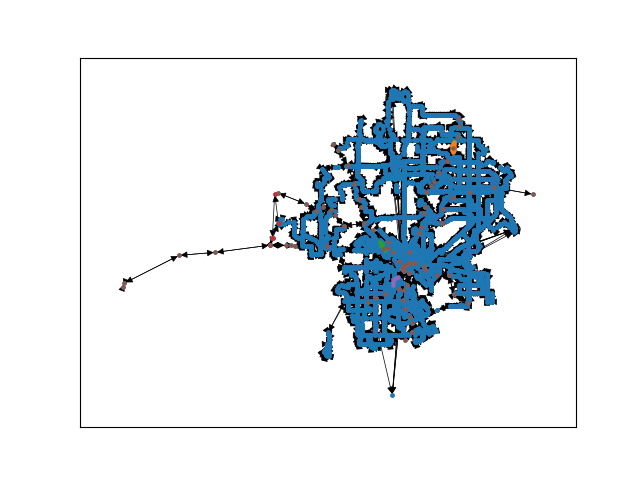

In [3]:
%matplotlib widget
pos = nx.get_node_attributes(G, "pos")

comps = list(nx.weakly_connected_components(G))

# Plot each weakly-connected component in its own color
nx.draw_networkx(G, pos=pos, node_size=5, width=0.5, with_labels=False)
colors = plt.get_cmap('tab10').colors # type: ignore

for component, color in zip(comps, colors):
    nx.draw_networkx(
        G.subgraph(component),
        pos=pos,
        node_color=[color],
        node_size=5,
        width=0.5,
        with_labels=False,
    )

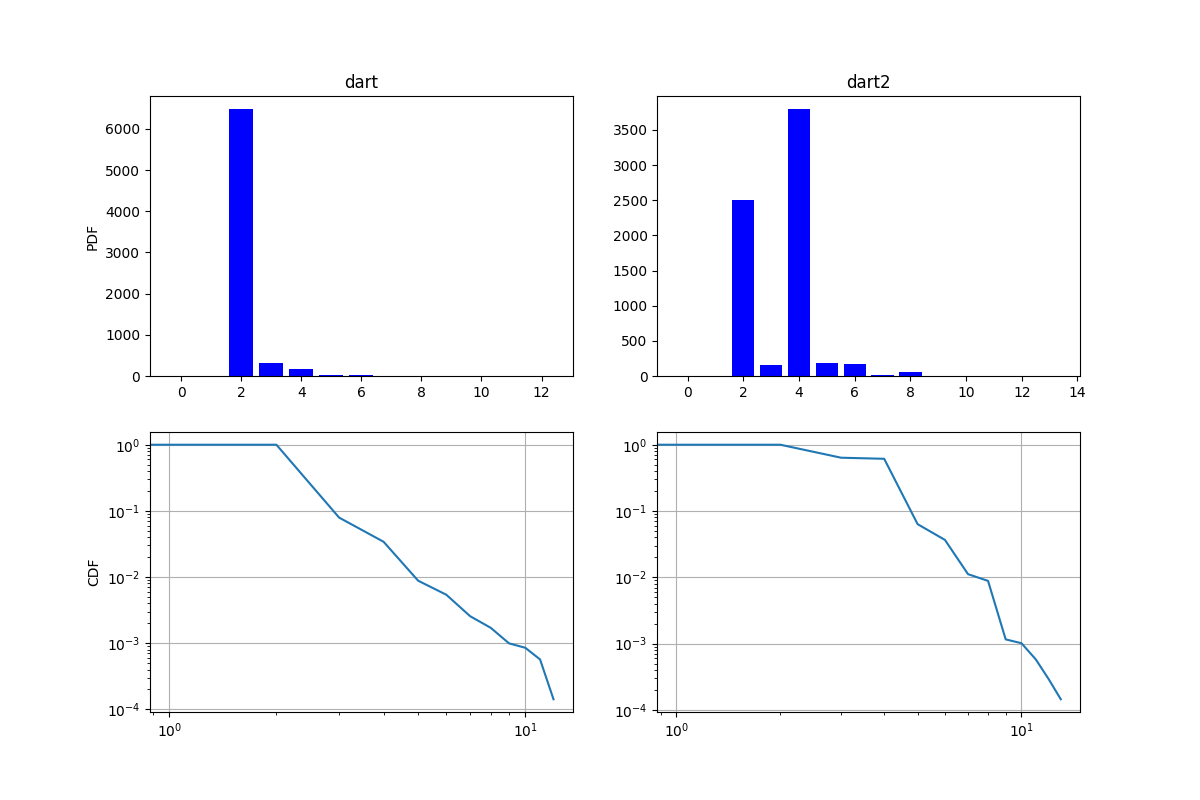

In [22]:
calc_powerlaw_multi({"dart": G, "dart2": G2})
plt.show()

In [16]:
# Reload powerlaw (if necessary)
# del calc_powerlaw_multi
# import powerlaw
# import importlib
# importlib.reload(powerlaw)

<module 'powerlaw' from 'c:\\Users\\Andrew\\Code\\dcns-project\\powerlaw.py'>

In [25]:
G2 = G.__class__(G.subgraph(max(nx.strongly_connected_components(G), key=len)))
nx.set_edge_attributes(G2, nx.get_edge_attributes(G2, "num_trips"), "weight")

In [29]:
close_edges = get_close_edges(nx.get_node_attributes(G2, "pos"), 0.0005, 50)
# Add 2-way edges for crossing the street
weight=1000
G2.add_weighted_edges_from(ebunch_to_add={(u, v, weight) for u, v in close_edges})
G2.add_weighted_edges_from(ebunch_to_add={(v, u, weight) for u, v in close_edges})

  1%|          | 26/2500 [00:00<00:00, 21024.08it/s]


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [94]:
%matplotlib widget
nx.draw(G2, pos=pos, node_size=5, width=0.5, with_labels=False)

In [8]:
v = nx.katz_centrality(G2)
sorted(v.items(), key=lambda x: x[1], reverse=True)[:5]

[('20431', 0.023891383133855137),
 ('33245', 0.01823958651197319),
 ('33221', 0.018066613885416992),
 ('33229', 0.017947073911942703),
 ('33286', 0.017170152312094938)]

In [12]:
v = nx.eigenvector_centrality(G)
sorted(v.items(), key=lambda x: x[1], reverse=True)[:5]

[('28264', 0.5368265196350608),
 ('22749', 0.4591515527756928),
 ('22748', 0.45889848812278444),
 ('28172', 0.2501210784473024),
 ('29825', 0.24689415583573063)]

In [11]:
nx.diameter(G2)
# Diameter = 356

356

In [21]:
nx.is_tree(G2)

False